In [7]:
# # Set up Git with your credentials
# !git config --global user.email "vinhnguyen.maths@gmail.com"
# !git config --global user.name "onemorestep-20"
# # Clone your GitHub repository
# !git clone https://github.com/onemorestep-20/TCA_BlockHouse.git

In [19]:
import shutil
import os

# Set up Git with your credentials
!git config --global user.email "vinhnguyen.maths@gmail.com"
!git config --global user.name "onemorestep-20"

# Remove the existing 'TCA_BlockHouse' directory if it exists
if os.path.exists('/content/TCA_BlockHouse'):
    shutil.rmtree('/content/TCA_BlockHouse')

# Clone your GitHub repository
!git clone https://github.com/onemorestep-20/TCA_BlockHouse.git

# Define the path to the Colab file you are working on
notebook_name = "TCA_VinhNGUYEN_BlockHouse"  # Your current notebook name without the .ipynb extension
colab_file_path = f'/content/{notebook_name}.ipynb'
destination_path = f'/content/TCA_BlockHouse/{notebook_name}.ipynb'

# Save the current notebook (if not already saved)
# This step is needed if you are saving the notebook from the Colab environment
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/path_to_your_colab_notebook/{notebook_name}.ipynb {colab_file_path}

# Check if the notebook exists
if os.path.exists(colab_file_path):
    # Copy the Colab file to the cloned repository directory
    shutil.copy(colab_file_path, destination_path)

    # Change directory to the cloned repository
    %cd /content/TCA_BlockHouse

    # Add the file to the Git index
    !git add {notebook_name}.ipynb

    # Commit the changes with a message
    !git commit -m "Add initial Colab file"

    # Push the changes to GitHub
    !git push origin main
else:
    print(f"File {colab_file_path} does not exist.")




Cloning into 'TCA_BlockHouse'...
Mounted at /content/drive
cp: cannot stat '/content/drive/MyDrive/path_to_your_colab_notebook/TCA_VinhNGUYEN_BlockHouse.ipynb': No such file or directory
File /content/TCA_VinhNGUYEN_BlockHouse.ipynb does not exist.


# 1. Import relevant libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

# 2. Download data from Yahoo Finance

In [2]:
# Set seed for reproducibility
np.random.seed(10)

# Data Collection for 2023
ticker = 'GME'
data = yf.download(ticker, start='2023-01-01', end='2023-12-31', interval='1d')

[*********************100%%**********************]  1 of 1 completed


# 3. Feature Engineering and Preprocessing data

In [3]:

# Calculate Amihud illiquidity measure
data['Return'] = data['Adj Close'].pct_change()
data['Dollar Volume'] = data['Volume'] * data['Adj Close']
data['Amihud Illiquidity'] = np.abs(data['Return']) / data['Dollar Volume']

# Calculate rolling volatility (20-day standard deviation of returns)
data['Volatility'] = data['Return'].rolling(window=20).std()

# Drop rows with NaN values
data.dropna(inplace=True)



# 4. We choose spline fitting to capture non-linear and smooth variations over time for the following parameters:

beta: Represents the linear impact of trade size on the transaction cost.

gamma: Represents the quadratic impact of trade size on the transaction cost (market impact).

delta: Represents the impact of liquidity on the transaction cost.


epsilon: Represents the impact of volatility on the transaction cost.

In [4]:

# Generate random trade sizes for the sake of this example
data['Trade Size'] = np.random.randint(100, 2000, size=len(data))

# Create time index for splines
time_index = np.arange(len(data))

# Fit initial spline models with UnivariateSpline
def fit_initial_splines(time_index):
    initial_beta = np.random.rand(len(time_index))
    initial_gamma = np.random.rand(len(time_index))
    initial_delta = np.random.rand(len(time_index))
    initial_epsilon = np.random.rand(len(time_index))

    spline_beta = UnivariateSpline(time_index, initial_beta, s=0)
    spline_gamma = UnivariateSpline(time_index, initial_gamma, s=0)
    spline_delta = UnivariateSpline(time_index, initial_delta, s=0)
    spline_epsilon = UnivariateSpline(time_index, initial_epsilon, s=0)

    return spline_beta, spline_gamma, spline_delta, spline_epsilon

# Fit initial splines
spline_beta, spline_gamma, spline_delta, spline_epsilon = fit_initial_splines(time_index)

# Define a function to extract control points from splines for optimization
def extract_spline_control_points(splines):
    control_points = []
    for spline in splines:
        control_points.append(spline.get_coeffs())
    return np.concatenate(control_points)

# Define a function to update spline models with optimized control points
def update_spline_models(control_points, time_index):
    num_points = len(time_index)
    beta_points = control_points[0:num_points]
    gamma_points = control_points[num_points:2*num_points]
    delta_points = control_points[2*num_points:3*num_points]
    epsilon_points = control_points[3*num_points:4*num_points]

    spline_beta = UnivariateSpline(time_index, beta_points, s=0)
    spline_gamma = UnivariateSpline(time_index, gamma_points, s=0)
    spline_delta = UnivariateSpline(time_index, delta_points, s=0)
    spline_epsilon = UnivariateSpline(time_index, epsilon_points, s=0)

    return spline_beta, spline_gamma, spline_delta, spline_epsilon


# 5. Define Objective function and optimize it

In [5]:
# Cost Function incorporating time-varying parameters
def transaction_cost(beta_t, gamma_t, delta_t, epsilon_t, trade_size, liquidity, volatility):
    alpha = 1000  # Set alpha to a sufficiently high fixed cost to ensure positivity
    market_impact = beta_t * trade_size + gamma_t * (trade_size ** 2)
    cost = alpha + market_impact + delta_t * liquidity + epsilon_t * volatility
    return cost

# Define Optimization Problem with regularization term
def objective(control_points):
    # Update splines with current control points
    spline_beta, spline_gamma, spline_delta, spline_epsilon = update_spline_models(control_points, time_index)

    # Predict parameters over time using the updated splines
    beta_t = spline_beta(time_index)
    gamma_t = spline_gamma(time_index)
    delta_t = spline_delta(time_index)
    epsilon_t = spline_epsilon(time_index)

    trade_size = data['Trade Size'].values  # Variable trade sizes
    liquidity = data['Amihud Illiquidity'].values
    volatility = data['Volatility'].values

    costs = transaction_cost(beta_t, gamma_t, delta_t, epsilon_t, trade_size, liquidity, volatility)
    regularization = np.sum(np.square(control_points))  # L2 regularization
    total_cost = np.sum(costs) + 1e4 * regularization  # Add regularization term to prevent overfitting
    return total_cost  # Sum of all transaction costs plus regularization

# Extract initial control points from the initial splines
initial_control_points = extract_spline_control_points([spline_beta, spline_gamma, spline_delta, spline_epsilon])



# Ensure the initial control points match the length of the time index
assert len(initial_control_points) == 4 * len(time_index)

# Constraints to ensure reasonable parameter values
constraints = [
    {'type': 'ineq', 'fun': lambda x: x[0]},  # beta >= 0
    {'type': 'ineq', 'fun': lambda x: x[2]},  # delta >= 0
    {'type': 'ineq', 'fun': lambda x: x[3]}   # epsilon >= 0
]

# Bounds to limit the magnitude of the parameters
bounds = [(0, 10)] * len(initial_control_points)  # Adjust bounds as needed

# Run Optimization using library SCIPY
result = minimize(objective, initial_control_points, method='SLSQP', constraints=constraints, bounds=bounds)

# Print optimized parameters (control points)
#print("Optimized Control Points:", result.x)

# Apply the optimized control points to update spline models and calculate transaction costs
spline_beta, spline_gamma, spline_delta, spline_epsilon = update_spline_models(result.x, time_index)

# Predict parameters over time using the updated splines
beta_t = spline_beta(time_index)
gamma_t = spline_gamma(time_index)
delta_t = spline_delta(time_index)
epsilon_t = spline_epsilon(time_index)

# Calculate transaction costs with time-varying parameters
trade_size = data['Trade Size'].values
liquidity = data['Amihud Illiquidity'].values
volatility = data['Volatility'].values

transaction_costs = transaction_cost(beta_t, gamma_t, delta_t, epsilon_t, trade_size, liquidity, volatility)



# 6. Visualization the Transaction Cost and relevant parameter in time

---



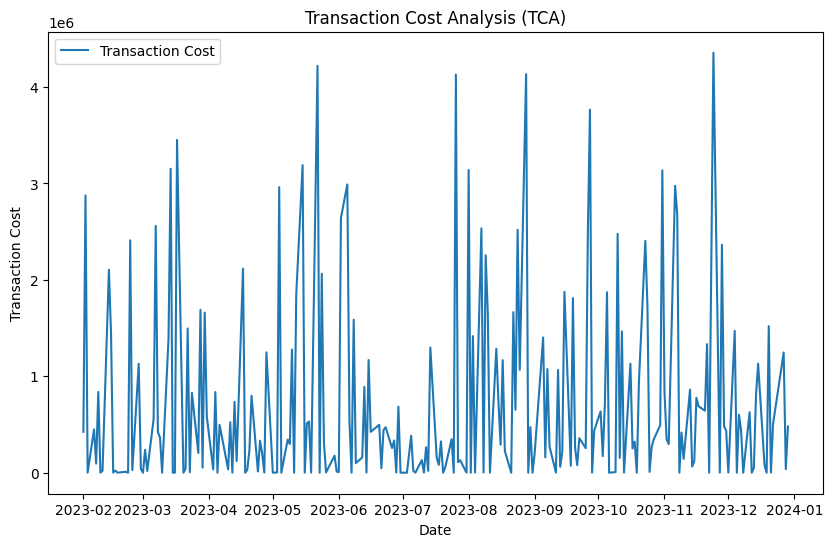

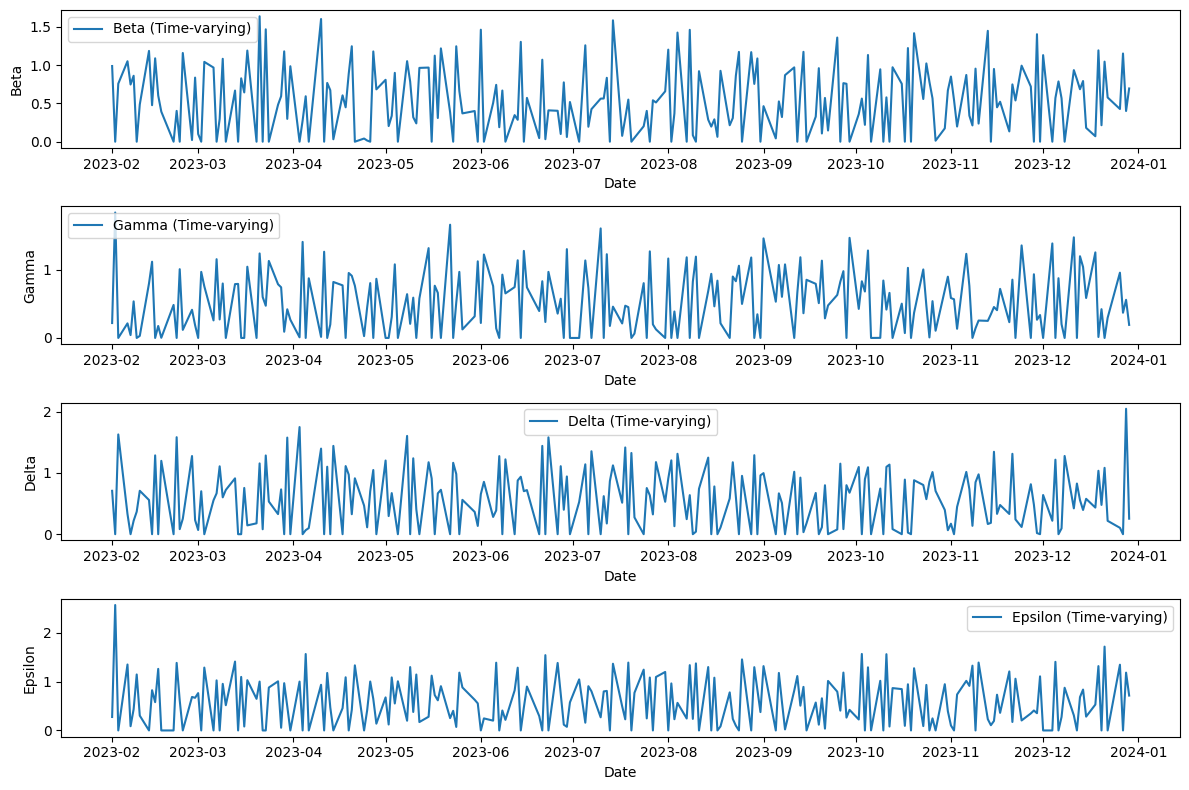

In [6]:
# Plot the transaction costs
plt.figure(figsize=(10, 6))
plt.plot(data.index, transaction_costs, label='Transaction Cost')
plt.xlabel('Date')
plt.ylabel('Transaction Cost')
plt.title('Transaction Cost Analysis (TCA)')
plt.legend()
plt.show()




# Plot the time-varying parameters
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(data.index, beta_t, label='Beta (Time-varying)')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(data.index, gamma_t, label='Gamma (Time-varying)')
plt.xlabel('Date')
plt.ylabel('Gamma')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(data.index, delta_t, label='Delta (Time-varying)')
plt.xlabel('Date')
plt.ylabel('Delta')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(data.index, epsilon_t, label='Epsilon (Time-varying)')
plt.xlabel('Date')
plt.ylabel('Epsilon')
plt.legend()

plt.tight_layout()
plt.show()
